In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt

%matplotlib inline

### Create encoder

In [2]:
def encoder_block(in_channels, out_channels, kernel_size=4, 
                  stride=2, padding=1, use_bias=False, batch_norm=True):
    layers = []
    layers.append(nn.Conv2d(in_channels=in_channels, 
                            out_channels=out_channels, 
                            kernel_size=kernel_size, 
                            stride=stride, 
                            padding=padding, 
                            bias=use_bias))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [3]:
input_size = (1, 3, 256, 256)

x = torch.empty(input_size).normal_()
print(x.size())

torch.Size([1, 3, 256, 256])


In [4]:
input_channel = 3
filter_size = 64

e1 = encoder_block(input_channel, filter_size, use_bias=True, batch_norm=False)
e2 = encoder_block(filter_size, filter_size * 2)
e3 = encoder_block(filter_size * 2, filter_size * 4)
e4 = encoder_block(filter_size * 4, filter_size * 8)
e5 = encoder_block(filter_size * 8, filter_size * 8)

In [5]:
output1 = e1(x)
output2 = e2(output1)
output3 = e3(output2)
output4 = e4(output3)
output5 = e5(output4)


print("Shape:", output1.shape)
print("Shape:", output2.shape)
print("Shape:", output3.shape)
print("Shape:", output4.shape)
print("Shape:", output5.shape)

Shape: torch.Size([1, 64, 128, 128])
Shape: torch.Size([1, 128, 64, 64])
Shape: torch.Size([1, 256, 32, 32])
Shape: torch.Size([1, 512, 16, 16])
Shape: torch.Size([1, 512, 8, 8])


### Decoder

In [6]:
def decoder_block(in_channels, out_channels, kernel_size=4, 
                  stride=2, padding=1, use_bias=False, batch_norm=True):
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels=in_channels, 
                                     out_channels=out_channels, 
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=padding,
                                     bias=use_bias))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [7]:
input_size = (1, 512, 1, 1)

x = torch.empty(input_size).normal_()
print(x.size())

torch.Size([1, 512, 1, 1])


In [8]:
d1 = decoder_block(filter_size * 8, filter_size * 8)
d2 = decoder_block(filter_size * 8, filter_size * 8)
d3 = decoder_block(filter_size * 8, filter_size * 8)
d4 = decoder_block(filter_size * 8, filter_size * 6)
d5 = decoder_block(filter_size * 6, filter_size * 4)
d6 = decoder_block(filter_size * 4, filter_size * 2)
d7 = decoder_block(filter_size * 2, filter_size)

d8 = nn.ConvTranspose2d(filter_size, 3, 4, 2, 1)

In [9]:
do1 = d1(x)
do2 = d2(do1)
do3 = d3(do2)
do4 = d4(do3)
do5 = d5(do4)
do6 = d6(do5)
do7 = d7(do6)
do8 = d8(do7)

print(do1.size())
print(do2.size())
print(do3.size())
print(do4.size())
print(do5.size())
print(do6.size())
print(do7.size())
print(do8.size())

torch.Size([1, 512, 2, 2])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 8, 8])
torch.Size([1, 384, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 128, 64, 64])
torch.Size([1, 64, 128, 128])
torch.Size([1, 3, 256, 256])


In [10]:
data = do8[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


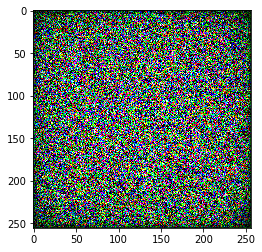

In [11]:
plt.imshow(np.transpose(do8[0].detach().numpy(), (1, 2, 0)));

### Residual Block

In [12]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, batch_norm=True):
    """Return sequence layer with Conv2D and BatchNormalization layer
    Params:
    in_channel: no. of input channel
    out_channel: no. of output channel
    kernel_size: kernel size of filter
    stride: stride of filter
    padding: pads the layer
    bias: create the bias weight
    batch_norm: create batch normalization layer
    
    return:
    nn.Sequence layer
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, 
                           out_channels=out_channels, 
                           kernel_size=kernel_size,
                           stride=stride, 
                           padding=padding, 
                           bias=bias)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)
    

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv(conv_dim, conv_dim, 
                          kernel_size=3, stride=1, padding=1, 
                          batch_norm=True)
        self.conv2 = conv(conv_dim, conv_dim, 
                          kernel_size=3, stride=1, padding=1, 
                          batch_norm=True)
        
    def forward(self, x):
        out_1 = F.relu(self.conv1(x))
        out_2 = x + self.conv2(out_1)
        return out_2

In [14]:
input_size = (2, 512, 1, 1)

x = torch.empty(input_size).normal_()
print(x.size())

torch.Size([2, 512, 1, 1])


In [15]:
res_block = ResidualBlock(512)

In [16]:
out = res_block(x)

In [17]:
out.size()

torch.Size([2, 512, 1, 1])

### The Generator

In [18]:
class Generator(nn.Module):
    def __init__(self, conv_dim=64, n_res_block=9):
        super(Generator, self).__init__()
        
        # 256 x 256 x 3
        self.conv1 = encoder_block(3, conv_dim, use_bias=True, batch_norm=False) # 128 x 128 x 64
        self.conv2 = encoder_block(conv_dim, conv_dim * 2) # 64 x 64 x 128
        self.conv3 = encoder_block(conv_dim * 2, conv_dim * 4) # 32 x 32 x 256
        self.conv4 = encoder_block(conv_dim * 4, conv_dim * 8) # 16 x 16 x 512
        self.conv5 = encoder_block(conv_dim * 8, conv_dim * 8) # 8 x 8 x 512
        self.conv6 = encoder_block(conv_dim * 8, conv_dim * 8) # 4 x 4 x 512
        self.conv7 = encoder_block(conv_dim * 8, conv_dim * 8) # 2 x 2 x 512
        self.conv8 = encoder_block(conv_dim * 8, conv_dim * 8) # 1 x 1 x 512
        
        res_layers = []
        for i in range(n_res_block):
            res_layers.append(ResidualBlock(conv_dim * 8))
            
        self.res_blocks = nn.Sequential(*res_layers)
        
        # 1 x 1 x 512
        self.deconv1 = decoder_block(conv_dim * 8, conv_dim * 8) # 2 x 2 x 512
        self.deconv2 = decoder_block(conv_dim * 8, conv_dim * 8) # 4 x 4 x 512
        self.deconv3 = decoder_block(conv_dim * 8, conv_dim * 8) # 8 x 8 x 512
        self.deconv4 = decoder_block(conv_dim * 8, conv_dim * 8) # 16 x 16 x 512
        self.deconv5 = decoder_block(conv_dim * 8, conv_dim * 4) # 32 x 32 x 256
        self.deconv6 = decoder_block(conv_dim * 4, conv_dim * 2) # 64 x 64 x 128
        self.deconv7 = decoder_block(conv_dim * 2, conv_dim) # 128 x 128 x 64
        self.deconv8 = decoder_block(conv_dim, 3, batch_norm=False)
        
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = F.leaky_relu(self.conv5(out), 0.2)
        out = F.leaky_relu(self.conv6(out), 0.2)
        out = F.leaky_relu(self.conv7(out), 0.2)
        out = F.leaky_relu(self.conv8(out), 0.2)
        
        out = self.res_blocks(out)
        
        out = F.leaky_relu(self.deconv1(out))
        out = F.leaky_relu(self.deconv2(out))
        out = F.leaky_relu(self.deconv3(out))
        out = F.leaky_relu(self.deconv4(out))
        out = F.leaky_relu(self.deconv5(out))
        out = F.leaky_relu(self.deconv6(out))
        out = F.leaky_relu(self.deconv7(out))
        
        out = torch.tanh(self.deconv8(out))
        
        return out
        
    
    

In [19]:
pix2pix_gen = Generator()

In [20]:
input_size = (1, 3, 256, 256)

x = torch.empty(input_size).normal_()
print(x.size())

torch.Size([1, 3, 256, 256])


In [21]:
pix2pix_gen.eval()
out = pix2pix_gen(x)

In [22]:
out.size()

torch.Size([1, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


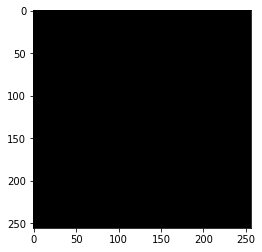

In [23]:
plt.imshow(np.transpose(out[0].detach().numpy(), (1, 2, 0)));

In [30]:
class Generator128(nn.Module):
    def __init__(self, conv_dim=64, n_res_block=9):
        super(Generator128, self).__init__()
        
        # 128 x 128 x 3
        self.conv1 = encoder_block(3, conv_dim, use_bias=True, batch_norm=False) # 64 x 64 x 64
        self.conv2 = encoder_block(conv_dim, conv_dim * 2) # 32 x 32 x 128
        self.conv3 = encoder_block(conv_dim * 2, conv_dim * 4) # 16 x 16 x 256
        self.conv4 = encoder_block(conv_dim * 4, conv_dim * 8) # 8 x 8 x 512
        self.conv5 = encoder_block(conv_dim * 8, conv_dim * 8) # 4 x 4 x 512
        self.conv6 = encoder_block(conv_dim * 8, conv_dim * 8) # 2 x 2 x 512
        self.conv7 = encoder_block(conv_dim * 8, conv_dim * 8) # 1 x 1 x 512
        
        res_layers = []
        for i in range(n_res_block):
            res_layers.append(ResidualBlock(conv_dim * 8))
            
        self.res_blocks = nn.Sequential(*res_layers)
        
        # 1 x 1 x 512
        self.deconv1 = decoder_block(conv_dim * 8, conv_dim * 8) # 2 x 2 x 512
        self.deconv2 = decoder_block(conv_dim * 8, conv_dim * 8) # 4 x 4 x 512
        self.deconv3 = decoder_block(conv_dim * 8, conv_dim * 8) # 8 x 8 x 512
        self.deconv4 = decoder_block(conv_dim * 8, conv_dim * 8) # 16 x 16 x 512
        self.deconv5 = decoder_block(conv_dim * 8, conv_dim * 4) # 32 x 32 x 256
        self.deconv6 = decoder_block(conv_dim * 4, conv_dim * 2) # 64 x 64 x 128
        self.deconv7 = decoder_block(conv_dim * 2, 3, batch_norm=False) # 128 x 128 x 64
        
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = F.leaky_relu(self.conv5(out), 0.2)
        out = F.leaky_relu(self.conv6(out), 0.2)
        out = F.leaky_relu(self.conv7(out), 0.2)
        
        out = self.res_blocks(out)
        
        out = F.leaky_relu(self.deconv1(out))
        out = F.leaky_relu(self.deconv2(out))
        out = F.leaky_relu(self.deconv3(out))
        out = F.leaky_relu(self.deconv4(out))
        out = F.leaky_relu(self.deconv5(out))
        out = F.leaky_relu(self.deconv6(out))
        out = torch.tanh(self.deconv7(out))
        
        return out
        
    
    

In [31]:
input_size = (1, 3, 128, 128)

x = torch.empty(input_size).normal_()
print(x.size())

torch.Size([1, 3, 128, 128])


In [32]:
gen_128 = Generator128()

gen_128.eval()

out = gen_128(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


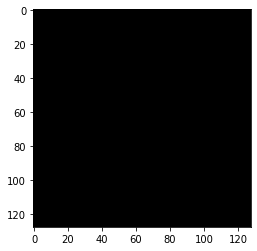

In [33]:
plt.imshow(np.transpose(out[0].detach().numpy(), (1, 2, 0)));